In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["TRITON_DISABLE_LINE_INFO"] = "1"

import torch
import triton
import triton.language as tl

DEVICE = 'cuda:0'

In [2]:
@triton.jit
def softmax_kernel_2pass(x_ptr, z_ptr, N0, T, BLOCK_SIZE: tl.constexpr):
    """2-pass softmax kernel"""
    row_id = tl.program_id(0)
    if row_id >= N0:
        return
    
    x_row_ptr = x_ptr + row_id * T
    z_row_ptr = z_ptr + row_id * T
    
    if T <= BLOCK_SIZE:
        col_offsets = tl.arange(0, BLOCK_SIZE)
        mask = col_offsets < T
        
        x_vals = tl.load(x_row_ptr + col_offsets, mask=mask, other=float('-inf'))
        x_max = tl.max(x_vals, axis=0)
        x_shifted = x_vals - x_max
        numerator = tl.exp(x_shifted)
        denominator = tl.sum(numerator, axis=0)
        result = numerator / denominator
        
        tl.store(z_row_ptr + col_offsets, result, mask=mask)
    else:
        num_blocks = (T + BLOCK_SIZE - 1) // BLOCK_SIZE
        
        # Pass 1: Find max and compute sum in one pass
        global_max = float('-inf')
        total_sum = 0.0
        
        for i in range(num_blocks):
            start = i * BLOCK_SIZE
            col_offsets = start + tl.arange(0, BLOCK_SIZE)
            mask = col_offsets < T
            
            vals = tl.load(x_row_ptr + col_offsets, mask=mask, other=float('-inf'))
            block_max = tl.max(vals, axis=0)
            
            if block_max > global_max:
                if i > 0:
                    total_sum = total_sum * tl.exp(global_max - block_max)
                global_max = block_max
            
            exp_vals = tl.exp(vals - global_max)
            block_sum = tl.sum(exp_vals, axis=0)
            total_sum += block_sum
        
        # Pass 2: Normalize and store
        for i in range(num_blocks):
            start = i * BLOCK_SIZE
            col_offsets = start + tl.arange(0, BLOCK_SIZE)
            mask = col_offsets < T
            
            vals = tl.load(x_row_ptr + col_offsets, mask=mask, other=0.0)
            exp_vals = tl.exp(vals - global_max)
            normalized = exp_vals / total_sum
            
            tl.store(z_row_ptr + col_offsets, normalized, mask=mask)

@triton.jit
def softmax_kernel_3pass(x_ptr, z_ptr, N0, T, BLOCK_SIZE: tl.constexpr):
    """3-pass softmax kernel"""
    row_id = tl.program_id(0)
    if row_id >= N0:
        return
    
    x_row_ptr = x_ptr + row_id * T
    z_row_ptr = z_ptr + row_id * T
    
    if T <= BLOCK_SIZE:
        col_offsets = tl.arange(0, BLOCK_SIZE)
        mask = col_offsets < T
        
        x_vals = tl.load(x_row_ptr + col_offsets, mask=mask, other=float('-inf'))
        x_max = tl.max(x_vals, axis=0)
        x_shifted = x_vals - x_max
        numerator = tl.exp(x_shifted)
        denominator = tl.sum(numerator, axis=0)
        result = numerator / denominator
        
        tl.store(z_row_ptr + col_offsets, result, mask=mask)
    else:
        num_blocks = (T + BLOCK_SIZE - 1) // BLOCK_SIZE
        
        # Pass 1: Find max
        global_max = float('-inf')
        for i in range(num_blocks):
            start = i * BLOCK_SIZE
            col_offsets = start + tl.arange(0, BLOCK_SIZE)
            mask = col_offsets < T
            
            vals = tl.load(x_row_ptr + col_offsets, mask=mask, other=float('-inf'))
            block_max = tl.max(vals, axis=0)
            global_max = tl.maximum(global_max, block_max)
        
        # Pass 2: Compute sum
        total_sum = 0.0
        for i in range(num_blocks):
            start = i * BLOCK_SIZE
            col_offsets = start + tl.arange(0, BLOCK_SIZE)
            mask = col_offsets < T
            
            vals = tl.load(x_row_ptr + col_offsets, mask=mask, other=0.0)
            exp_vals = tl.exp(vals - global_max)
            block_sum = tl.sum(exp_vals, axis=0)
            total_sum += block_sum
        
        # Pass 3: Normalize and store
        for i in range(num_blocks):
            start = i * BLOCK_SIZE
            col_offsets = start + tl.arange(0, BLOCK_SIZE)
            mask = col_offsets < T
            
            vals = tl.load(x_row_ptr + col_offsets, mask=mask, other=0.0)
            exp_vals = tl.exp(vals - global_max)
            normalized = exp_vals / total_sum
            
            tl.store(z_row_ptr + col_offsets, normalized, mask=mask)

def softmax_2pass(x: torch.Tensor) -> torch.Tensor:
    N0, T = x.shape
    z = torch.empty_like(x)
    BLOCK_SIZE = 1024
    grid = (N0, )
    softmax_kernel_2pass[grid](x, z, N0=N0, T=T, BLOCK_SIZE=BLOCK_SIZE)
    return z

def softmax_3pass(x: torch.Tensor) -> torch.Tensor:
    N0, T = x.shape
    z = torch.empty_like(x)
    BLOCK_SIZE = 1024
    grid = (N0, )
    softmax_kernel_3pass[grid](x, z, N0=N0, T=T, BLOCK_SIZE=BLOCK_SIZE)
    return z

def torch_softmax(x: torch.Tensor) -> torch.Tensor:
    return torch.softmax(x, axis=1)


In [3]:
# Performance benchmark
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['T'],
        x_vals=[128, 256, 512, 1024, 2048, 4096, 8192, 16384, 32768, 65536],
        x_log=True,
        line_arg='provider',
        line_vals=['2-pass', '3-pass', 'torch'],
        line_names=['Triton 2-Pass', 'Triton 3-Pass', 'Torch'],
        styles=[('blue', '-'), ('green', '-'), ('red', '-')],
        ylabel='GB/s',
        plot_name='softmax-2pass-vs-3pass-performance',
        args={'N0': 64},
    ))
def benchmark(N0, T, provider):
    x = torch.randn(N0, T, device=DEVICE, dtype=torch.float32)
    quantiles = [0.5, 0.2, 0.8]
    
    if provider == 'torch':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: torch_softmax(x), quantiles=quantiles)
    elif provider == '2-pass':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: softmax_2pass(x), quantiles=quantiles)
    elif provider == '3-pass':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: softmax_3pass(x), quantiles=quantiles)
        
    gbps = lambda ms: 2 * x.numel() * x.element_size() * 1e-9 / (ms * 1e-3)
    return gbps(ms), gbps(max_ms), gbps(min_ms)

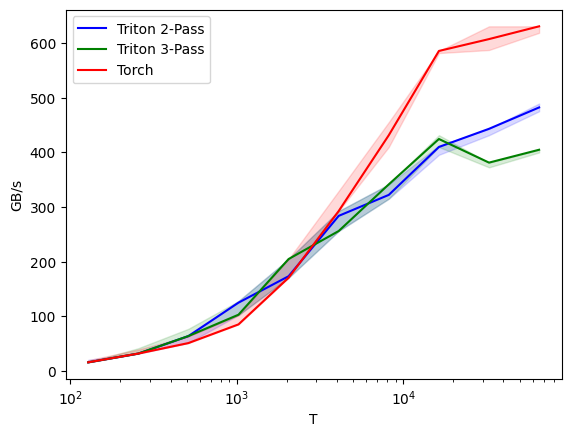

softmax-2pass-vs-3pass-performance:
         T  Triton 2-Pass  Triton 3-Pass       Torch
0    128.0      16.000000      16.000000   16.000000
1    256.0      32.000000      32.000000   32.000000
2    512.0      64.000000      64.000000   51.200001
3   1024.0     125.068709     103.044023   85.333330
4   2048.0     173.375663     204.800005  170.666661
5   4096.0     283.705630     256.000001  292.571425
6   8192.0     322.044215     341.333321  431.157914
7  16384.0     409.600010     424.181236  585.142849
8  32768.0     442.810792     381.023256  606.814814
9  65536.0     481.882344     404.543218  630.153853


In [4]:
benchmark.run(print_data=True, show_plots=True)